In [25]:
###9.1.5

from nilearn.datasets import fetch_spm_auditory
subject_data = fetch_spm_auditory()
subject_data.func  # print the list of names of functional images


Dataset created in /home/pierre/nilearn_data/spm_auditory

Data absent, downloading...


Downloaded 20725760 of 34212021 bytes (60.6%,    0.7s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/pierre/nilearn_data/spm_auditory/sub001/MoAEpilot.zip..... done.


['/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_009.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_010.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_011.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_012.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_013.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_014.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_015.img',
 '/home/pierre/nilearn_data/spm_auditory/sub001/fM00223/fM00223_016.img',
 '/home/pierre/nilearn_data/spm_audito

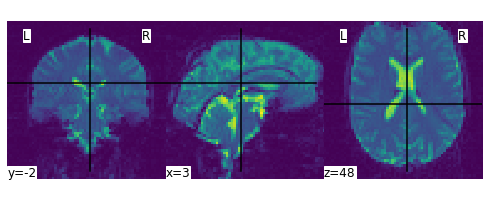

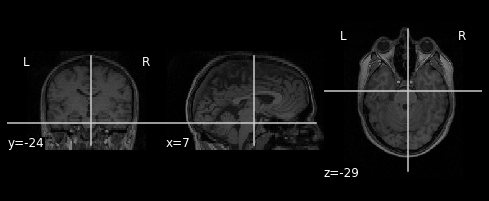

In [26]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
plot_img(subject_data.func[0])
plot_anat(subject_data.anat)

In [27]:
from nilearn.image import concat_imgs, mean_img
fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)

In [28]:
import pandas as pd
events = pd.read_table(subject_data['events'])
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


In [29]:
from nilearn.glm.first_level import FirstLevelModel

In [30]:
fmri_glm = FirstLevelModel(t_r=7,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

In [31]:
fmri_glm = fmri_glm.fit(fmri_img, events)

In [32]:
design_matrix = fmri_glm.design_matrices_[0]

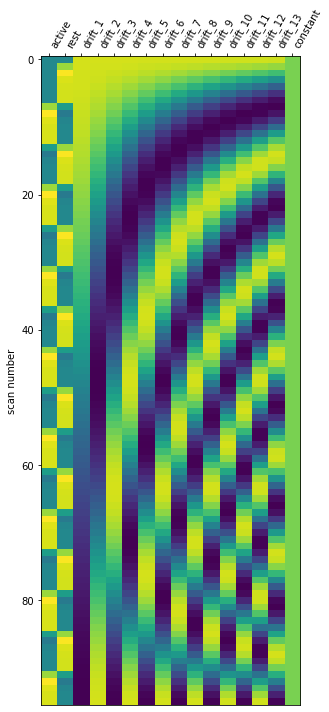

In [33]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

In [34]:
import os
outdir = 'results'
if not os.path.exists(outdir):
    os.mkdir(outdir)

from os.path import join
plot_design_matrix(
    design_matrix, output_file=join(outdir, 'design_matrix.png'))

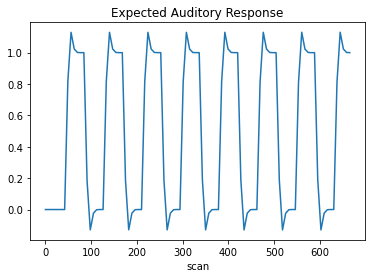

In [35]:
plt.plot(design_matrix['active'])
plt.xlabel('scan')
plt.title('Expected Auditory Response')
plt.show()

In [36]:
from numpy import array
conditions = {
    'active': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.]),
    'rest':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.]),
}

In [37]:
active_minus_rest = conditions['active'] - conditions['rest']

<AxesSubplot:label='conditions'>

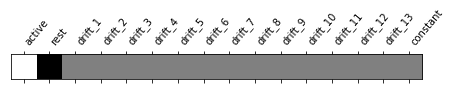

In [38]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

In [39]:
eff_map = fmri_glm.compute_contrast(active_minus_rest,
                                    output_type='effect_size')

In [40]:
z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

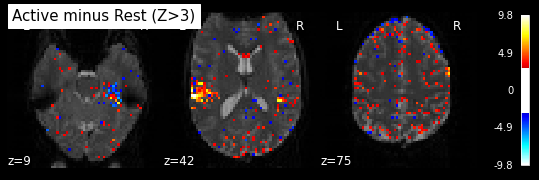

In [41]:
plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (Z>3)')
plt.show()

Uncorrected p<0.001 threshold: 3.291


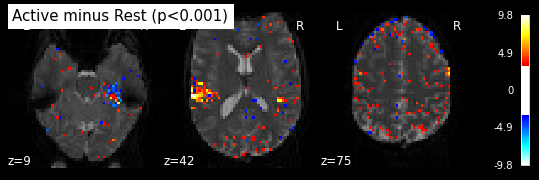

In [42]:
from nilearn.glm import threshold_stats_img
_, threshold = threshold_stats_img(z_map, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (p<0.001)')
plt.show()

False Discovery rate = 0.05 threshold: 2.904


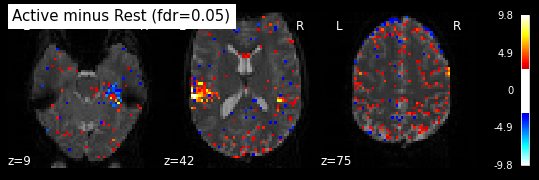

In [43]:
_, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
print('False Discovery rate = 0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (fdr=0.05)')
plt.show()

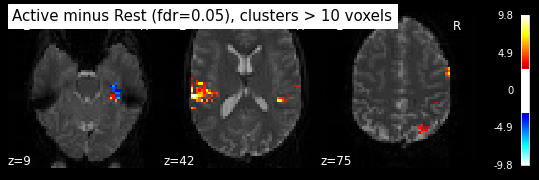

In [44]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (fdr=0.05), clusters > 10 voxels')
plt.show()

In [45]:
z_map.to_filename(join(outdir, 'active_vs_rest_z_map.nii.gz'))
eff_map.to_filename(join(outdir, 'active_vs_rest_eff_map.nii.gz'))

In [46]:
from nilearn.reporting import get_clusters_table
table = get_clusters_table(z_map, stat_threshold=threshold,
                           cluster_threshold=20)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-60.0,-6.0,42.0,9.811979,4050
1,1a,-63.0,6.0,36.0,8.601922,
2,1b,-63.0,0.0,42.0,8.435063,
3,1c,-48.0,-15.0,39.0,8.364058,
4,2,60.0,0.0,36.0,9.605128,1512
5,2a,45.0,-12.0,42.0,7.590200,
6,3,63.0,12.0,27.0,8.253889,972
7,3a,51.0,3.0,30.0,6.968355,
8,3b,54.0,9.0,39.0,3.565609,
9,4,36.0,-3.0,15.0,8.087451,1188


In [47]:
table.to_csv(join(outdir, 'table.csv'))

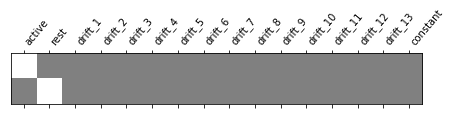

In [48]:
import numpy as np
effects_of_interest = np.vstack((conditions['active'], conditions['rest']))
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

z_map = fmri_glm.compute_contrast(effects_of_interest,
                                  output_type='z_score')

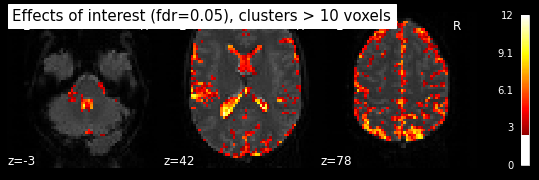

In [49]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Effects of interest (fdr=0.05), clusters > 10 voxels')
plt.show()